# L0. Introduction

### Define all the imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Change to main folder for the imports
sys.path.append('/home/ericguerrero/lib/probabilistic_robotics')

In [2]:
from src.data.reader import Reader

### Define new Functions

In [3]:
def build_timeseries(data,cols):
    timeseries = pd.DataFrame(data, columns=cols)
    timeseries['stamp'] = pd.to_datetime(timeseries['stamp'], unit='s')
    timeseries = timeseries.set_index('stamp')
    return timeseries

def filter_static_landmarks(lm, barcodes):
    for L,l in dict(barcodes).items(): # Translate barcode num to landmark num
        lm[lm==l]=L
    lm = lm[lm.type > 5] # Keep only static landmarks 
    return lm 

### Load a dataset

In [4]:
# Define dataset to read
dataset = "../data/MRCLAM_Dataset4" # Dataset
end_frame = 10000 # Extension of the dataset
robot = 'Robot2' # Robot

# Reader. Go to the src directory using VScode and inspect the class methods
self = Reader(dataset, robot, end_frame)

### Generate some representations

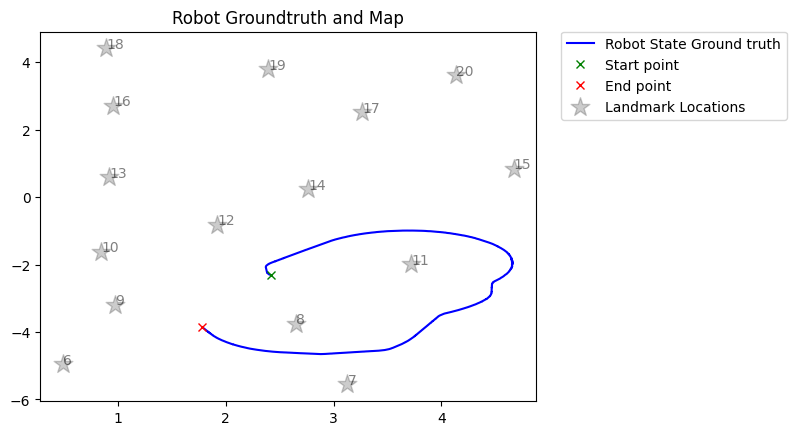

In [19]:
# Ground truth data
plt.plot(self.groundtruth_data[:, 1], self.groundtruth_data[:, 2], 'b', label="Robot State Ground truth")

# Start and end points
plt.plot(self.groundtruth_data[0, 1], self.groundtruth_data[0, 2], 'gx', label="Start point")
plt.plot(self.groundtruth_data[-1, 1], self.groundtruth_data[-1, 2], 'rx', label="End point")

# Landmark ground truth locations and indexes
landmark_xs = []
landmark_ys = []
for location in self.landmark_locations:
    landmark_xs.append(self.landmark_locations[location][0])
    landmark_ys.append(self.landmark_locations[location][1])
    index = self.landmark_indexes[location] + 5
    plt.text(landmark_xs[-1], landmark_ys[-1], str(index), alpha=0.5, fontsize=10)
plt.scatter(landmark_xs, landmark_ys, s=200, c='k', alpha=0.2, marker='*', label='Landmark Locations')

# plt.title("Localization with only odometry data")
plt.title("Robot Groundtruth and Map")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### TASK EXAMPLE. Represent landmark measurments

#### Import data into pandas dataframes

In [6]:
# Build dataframes
groundtruth = build_timeseries(self.groundtruth_data, cols=['stamp','x','y','theta'])
measurements = build_timeseries(self.data, cols=['stamp','type','range_l','bearing_l'])
odometry = measurements[measurements.type == -1].rename(columns={'range_l': 'v', 'bearing_l': 'omega'})
landmarks = measurements[measurements.type != -1]
landmarks = filter_static_landmarks(landmarks, self.barcodes_data)


/tmp/ipykernel_11620/370988952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lm[lm==l]=L
/tmp/ipykernel_11620/370988952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lm[lm==l]=L


In [7]:
groundtruth.head()

,x,y,theta
stamp,,,
2009-07-22 21:19:03.421999872,2.421160,-2.315331,2.3205
2009-07-22 21:19:03.438999808,2.421166,-2.315329,2.3205
2009-07-22 21:19:03.440999936,2.421169,-2.315331,2.3206
2009-07-22 21:19:03.456000000,2.421167,-2.315334,2.3207
2009-07-22 21:19:03.464000000,2.421161,-2.315335,2.3208


In [8]:
odometry.head()

,type,v,omega
stamp,,,
2009-07-22 21:19:13.448000000,-1.0,0.086,-0.398
2009-07-22 21:19:13.457999872,-1.0,0.086,-0.398
2009-07-22 21:19:13.499000064,-1.0,0.086,-0.398
2009-07-22 21:19:13.509999872,-1.0,0.086,-0.398
2009-07-22 21:19:13.540000000,-1.0,0.086,-0.398


In [9]:
landmarks.head()

,type,range_l,bearing_l
stamp,,,
2009-07-22 21:19:15.805999872,14.0,2.565,-0.250
2009-07-22 21:19:16.038000128,17.0,4.876,-0.279
2009-07-22 21:19:16.272000000,13.0,3.126,0.382
2009-07-22 21:19:16.272000000,20.0,5.884,-0.389
2009-07-22 21:19:16.522000128,20.0,5.884,-0.386


#### Transform landmark measurements to global coordinates
Join dataframes (link observations to particular GT locations)

In [10]:
data = landmarks.join(groundtruth).dropna()
data.head()

,type,range_l,bearing_l,x,y,theta
stamp,,,,,,
2009-07-22 21:19:22.716999936,17.0,4.104,0.506,2.496017,-1.861087,0.8879
2009-07-22 21:19:30.036000000,20.0,5.140,0.427,2.798803,-1.500381,0.8762
2009-07-22 21:19:30.273999872,20.0,5.064,0.436,2.810051,-1.489472,0.8816
2009-07-22 21:19:31.231000064,20.0,5.049,0.436,2.852543,-1.439212,0.8770
2009-07-22 21:19:34.220000000,15.0,2.873,0.111,2.983707,-1.290436,0.7981


Transform distance and bearin to global coordinates

In [11]:
range_l = data.range_l
bearing_l = data.bearing_l
x_t = data.x
y_t =  data.y
theta_t = data.theta

x = range_l*np.cos(bearing_l)
y = range_l*np.sin(bearing_l)

data['x_l'] = x_t + x*np.cos(theta_t) - y*np.sin(theta_t)
data['y_l'] = y_t + x*np.sin(theta_t) + y*np.cos(theta_t)
data.head()

,type,range_l,bearing_l,x,y,theta,x_l,y_l
stamp,,,,,,,,
2009-07-22 21:19:22.716999936,17.0,4.104,0.506,2.496017,-1.861087,0.8879,3.218219,2.178869
2009-07-22 21:19:30.036000000,20.0,5.140,0.427,2.798803,-1.500381,0.8762,4.157891,3.456683
2009-07-22 21:19:30.273999872,20.0,5.064,0.436,2.810051,-1.489472,0.8816,4.078582,3.413071
2009-07-22 21:19:31.231000064,20.0,5.049,0.436,2.852543,-1.439212,0.8770,4.139787,3.442939
2009-07-22 21:19:34.220000000,15.0,2.873,0.111,2.983707,-1.290436,0.7981,4.749039,0.976220


#### Represent measurements on top of our known map

/tmp/ipykernel_11620/4189250830.py:4: UserWarning: The palette list has more values (13) than needed (9), which may not be intended.
  sns.scatterplot(data,x="x_l",y="y_l", hue="type", palette=sns.color_palette("husl", num_landmarks),legend=False)


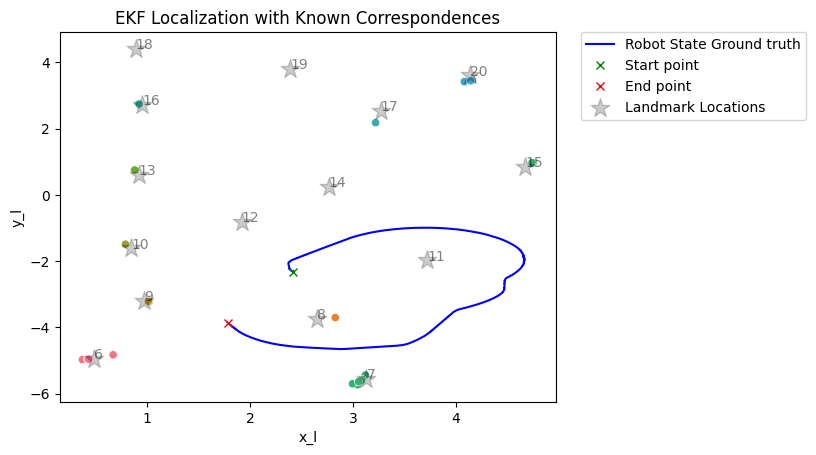

In [12]:
# REPRESENT
# Measurements (New added function)
num_landmarks = len(landmarks.type.unique())
sns.scatterplot(data,x="x_l",y="y_l", hue="type", palette=sns.color_palette("husl", num_landmarks),legend=False)    

# Ground truth data
plt.plot(self.groundtruth_data[:, 1], self.groundtruth_data[:, 2], 'b', label="Robot State Ground truth")

# Start and end points
plt.plot(self.groundtruth_data[0, 1], self.groundtruth_data[0, 2], 'gx', label="Start point")
plt.plot(self.groundtruth_data[-1, 1], self.groundtruth_data[-1, 2], 'rx', label="End point")

# Landmark ground truth locations and indexes
landmark_xs = []
landmark_ys = []
for location in self.landmark_locations:
    landmark_xs.append(self.landmark_locations[location][0])
    landmark_ys.append(self.landmark_locations[location][1])
    index = self.landmark_indexes[location] + 5
    plt.text(landmark_xs[-1], landmark_ys[-1], str(index), alpha=0.5, fontsize=10)
plt.scatter(landmark_xs, landmark_ys, s=200, c='k', alpha=0.2, marker='*', label='Landmark Locations')

# plt.title("Localization with only odometry data")
plt.title("Robot GT, Map and Absolute Measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### TASK 1. Get dataset specifications

#### Get path length
Sum displacements from the GT

#### Get duration

#### Get number of landmark measurements

#### Get distance between initial and end positions

#### Measurements density 
Mean number of measures per unit of distance

### TASK 2. Iterate over diferent datasets


#### Generate metrics

In [ ]:
datasets = ["../data/MRCLAM_Dataset1",
            "../data/MRCLAM_Dataset2",
            "../data/MRCLAM_Dataset3",
            "../data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

metrics = pd.Dataframe(columns=['dataset','robot','length','duration','n_landmarks','distance','m_density'])

for ds in datasets:
    for rob in robots:
        # Load data
        
        # Get metrics

#### Represent metrics
Use seaborn library (catplot)

In [15]:
# Represent metrics for all datasets

#### Analize metrics

In [16]:
# Analize the results and select three datasets with different 'distance','m_density' for the next lab sessions.